Ali Setareh Kokab 

Student ID: 95100491

MLP-HW1

Set the paramters of matplot plots to have beautiful plots 

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import io,requests 
from matplotlib import rcParams

rcParams['figure.figsize'] = 15,7
'''Set the defaults for your plots.'''
# plt.rcParams.update({'font.size': 20, 'figsize':(8,6)})
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('axes', linewidth = 5 )
plt.rc('lines', linewidth = 3 )

plt.rc('lines', markersize = 3 )

plt.rc('figure', figsize=(8,4) )         # Image size


get the ground state energies dataset

In [ ]:
url = 'https://www.dropbox.com/s/das9t6vwp7t4b7f/roboBohr.csv.zip?dl=1'
s=requests.get(url, stream=True).content
df=pd.read_csv(io.BytesIO(s) , compression='zip' , index_col=0)

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1237,1238,1239,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,pubchem_id,Eat
0,73.516695,17.817765,12.469551,12.458130,12.454607,12.447345,12.433065,12.426926,12.387474,12.365984,12.342823,12.335925,12.328055,12.284265,12.269844,12.247357,10.557967,10.473721,9.225262,8.448526,7.611145,7.610874,7.580510,7.579386,7.576929,7.536001,7.517317,7.462578,7.459865,7.456214,7.447581,7.443458,7.423496,7.345785,7.323741,7.247088,7.230886,6.662523,6.286251,6.134338,...,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,25004,-19.013763
1,73.516695,20.649126,18.527789,17.891535,17.887995,17.871731,17.852586,17.729842,15.864270,15.227643,15.202985,14.800045,12.855629,12.728858,12.618058,12.589962,12.557323,12.074893,10.607138,10.572061,10.464293,9.816674,9.456914,9.455816,8.865704,8.104048,8.006855,7.968817,7.946644,7.932943,7.922656,7.888724,7.885692,7.783220,7.637477,7.636586,7.631457,7.336591,7.127698,6.974135,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25005,-10.161019
2,73.516695,17.830377,12.512263,12.404775,12.394493,12.391564,12.324461,12.238106,10.423249,8.698826,7.607776,7.550253,7.446675,7.398848,7.381532,7.355045,7.321944,6.625986,6.116315,6.106397,6.098066,5.989868,5.731750,5.700963,5.371527,5.008911,4.894453,4.826545,4.352232,4.270598,2.902330,2.902220,2.901834,2.901089,2.900168,2.900151,2.899983,2.898772,2.898551,2.897620,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25006,-9.376619
3,73.516695,17.875810,17.871259,17.862402,17.850920,17.850440,12.558105,12.557645,12.517583,12.444141,12.420665,12.410312,12.346845,12.175480,12.098758,10.612802,10.610273,10.606738,10.606702,10.433290,8.694957,8.421582,8.103569,8.103345,7.595619,7.566897,7.555411,7.413109,7.403199,7.185256,6.915425,6.198245,6.191266,6.181797,6.152544,5.252689,5.244354,5.176740,5.176314,5.175577,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25009,-13.776438
4,73.516695,17.883818,17.868256,17.864221,17.818540,12.508657,12.490519,12.450098,10.597068,10.595914,10.485270,8.595823,8.103880,8.103567,7.975189,7.546413,7.503300,6.803380,6.738768,5.169492,5.161869,5.145972,4.924911,4.899245,4.534996,4.486310,3.897466,3.081523,2.957823,2.903069,2.902178,2.900610,2.900542,2.900306,2.899368,2.899113,2.897739,2.896793,2.896063,2.895051,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25011,-8.537140


let's see what our data looks like 

In [ ]:
des=df.describe()
des

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1237,1238,1239,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250,1251,1252,1253,1254,1255,1256,1257,1258,1259,1260,1261,1262,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272,1273,1274,pubchem_id,Eat
count,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,...,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000,16242.000000
mean,115.715266,22.445723,20.474191,18.529573,17.169350,15.816888,15.133152,14.471534,13.960759,13.464842,12.995648,12.536755,12.134472,11.725455,11.322985,10.942354,10.532980,10.185355,9.865138,9.550602,9.270908,8.992816,8.686932,8.438866,8.216404,8.001879,7.801071,7.619815,7.436879,7.230657,7.074353,6.926277,6.788862,6.656036,6.524501,6.398902,6.271766,6.122933,6.005082,5.893887,...,0.000152,0.000151,0.017793,0.000151,0.000150,0.000150,0.000149,0.000149,0.000148,0.000148,0.013976,0.000147,0.000146,0.000146,0.000145,0.000144,0.000144,0.010898,0.000143,0.000142,0.000141,0.000140,0.000140,0.008096,0.000139,0.000138,0.000137,0.000136,0.006003,0.000135,0.000134,0.000133,0.003879,0.000131,0.000129,0.002155,0.000127,0.001201,33107.484300,-11.178969
std,113.198503,8.659586,7.670481,6.485777,5.512560,4.179691,3.885091,3.503075,3.357136,3.140732,2.945697,3.061169,3.095441,3.116886,3.149103,3.103442,3.146188,3.118482,3.086087,3.053195,3.019009,2.978428,2.987763,2.938869,2.885130,2.827824,2.788062,2.750918,2.728532,2.741255,2.728023,2.695883,2.673679,2.652602,2.636786,2.618032,2.611301,2.616460,2.609501,2.599899,...,0.003097,0.003084,0.092632,0.003074,0.003064,0.003055,0.003042,0.003033,0.003020,0.003011,0.082421,0.002997,0.002982,0.002969,0.002954,0.002942,0.002931,0.073010,0.002915,0.002897,0.002882,0.002865,0.002851,0.063110,0.002835,0.002813,0.002794,0.002770,0.054458,0.002748,0.002728,0.002705,0.043869,0.002676,0.002633,0.032755,0.002594,0.024472,23456.785147,3.659133
min,36.858105,2.906146,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-23.245373
25%,73.516695,17.969345,16.228071,15.165862,13.744092,13.653146,13.637784,12.759519,12.587359,12.489127,12.420158,12.221616,10.644108,10.435522,9.174773,8.918565,8.212141,7.926422,7.882542,7.859861,7.663923,7.609426,7.560332,7.492887,7.349070,7.011791,6.826493,6.650346,6.286981,5.996581,5.782333,5.454539,5.234624,5.104931,5.024895,4.883677,4.584299,4.350308,4.171546,3.957122,...,0.000000,0.000000,0.000000,0.

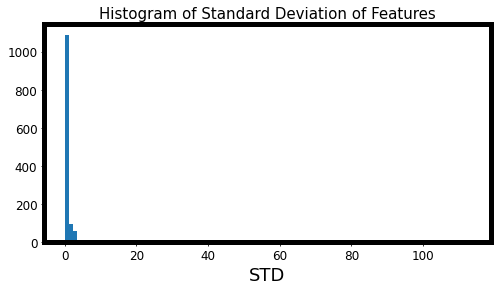

In [ ]:
plt.hist(np.sort(des.loc['std'][:1275]),bins=100)
plt.title('Histogram of Standard Deviation of Features')
plt.xlabel('STD')
plt.show()

Let's make our training matrix (X) which is a n_s*n_f matrix and y is output  vector 

In [ ]:
X=df.drop(['pubchem_id','Eat'],axis=1)
Y=df['Eat']
print(np.shape(X))
print(np.shape(Y))

(16242, 1275)
(16242,)


to compare the models, first we need to define a score which measures how well our model predictions are close to real values.The function score takes real values (Y) and the model prediction (Y_predict) and returns the score.

In [ ]:
def score(Y,Y_predict):
    return np.sqrt(np.mean((Y-Y_predict)**2))

# Question 1

## Brute force alghorithm

To find a linear fit using brute force alghoritm we should loop through each parameter and compute the score and in the end pick the group of coefficients which gives us the best score. So basically what we need is a 1275 (number of features) nested for loops to scan this space! It is almost impossible to do this. So what we do instead is first we build an array of lienar model coefficients and initiate it with random numbers between -1 and 1. Then we loop through each coefficent and try to minimum the score by varying that specific coefficient and keep other coefficients constant. This method definitely would not give us the best results but it is much more doable than try to scan the whole space. 

In [ ]:
#first lets scale both X and Y using min max scaler 
from sklearn.preprocessing import MinMaxScaler 
#firsts transform our data 
mm=MinMaxScaler()
x_mm=mm.fit_transform(X)
y_mm=mm.fit_transform(Y.to_numpy().reshape(-1,1))

array([[0.18844125],
       [0.5826699 ],
       [0.61760066],
       ...,
       [0.28695888],
       [0.4413229 ],
       [0.4412513 ]])

In [ ]:
%%time
c=(2*np.random.rand(1,1275)-1).reshape(-1,1)

for index,item in enumerate(c):
  print(index)
  b=np.arange(-1,1,0.1)
  scores=[]
  for cons in b:
    c[index]=cons
    scores.append(score(x_mm@c,y_mm))
  c[index]=b[np.argmin(scores)]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
print('the brute force score is %0.2f'%score(x_mm@c,y_mm))

the brute force score is 1.18


Now let's use the formula (X^t * X)^-1 * X^t *y to find the coefficients of the linear model. Note that this model does not need any learning and would find the solution in one step. 

In [ ]:
x_arr=X.to_numpy()
y_arr=Y.to_numpy()
coeff=np.linalg.pinv(np.transpose(x_arr)@x_arr)@(np.transpose(x_arr))@y_arr
coeff.reshape(-1,1) #the coefficient of the linear model. it is a vector of shape (1275,1)

array([[ 1.17131436e-02],
       [-1.38315528e-01],
       [ 1.53051721e-02],
       ...,
       [-2.75016360e+01],
       [-1.07303534e+03],
       [-4.40529901e-01]])

Text(0, 0.5, 'coefficient values')

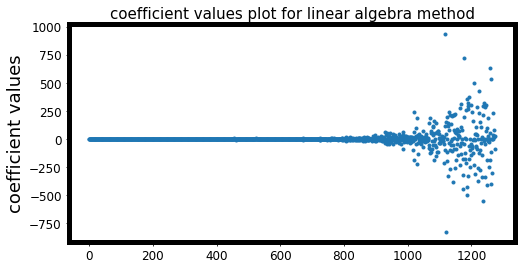

In [ ]:
plt.plot(coeff,'o')
plt.title('coefficient values plot for linear algebra method')
plt.ylabel('coefficient values')

# Question 2

in this part we want to compare different models. To be specific we will compare Ridge, KNN and SGD from sklearn 

In [ ]:
from sklearn.linear_model import Ridge,SGDRegressor
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
%%time
sgd=SGDRegressor(loss='squared_loss',alpha=0.0001,max_iter=1000,eta0=0.01,epsilon=0.01) #alpha is the learning rate. 
sgd.fit(X,Y)
sgd_score=score(sgd.predict(X),Y.values)

CPU times: user 9.63 s, sys: 3.07 ms, total: 9.63 s
Wall time: 9.64 s


In [ ]:
%%time
rg=Ridge()
rg.fit(X,Y)
Y_pred_ridge=rg.predict(X)
ridge_score=score(Y.values,Y_pred_ridge)

CPU times: user 2.09 s, sys: 250 ms, total: 2.34 s
Wall time: 1.26 s


In [ ]:
%%time
knn=KNeighborsRegressor(n_neighbors=2)
knn.fit(X,Y)
Y_pred_knn=knn.predict(X)
knn_score=score(Y.values,Y_pred_knn)


CPU times: user 1min 39s, sys: 29.1 ms, total: 1min 39s
Wall time: 1min 39s


In [ ]:
print('the sgd score is {0:.2f}, the ridge score is {1:.2f} and the KNN score is {2:.2f}'.format(sgd_score,ridge_score,knn_score))

the sgd score is 8672064074754.05, the ridge score is 0.71 and the KNN score is 0.28


as you can see the SGD has the poorest performance and the KNN is the best. Now let's scale our data and see if our results change. We use min-max scaler, standardscaler and robustscaler and compare the results. 

# Question 4

In [ ]:
%%time
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler

s_scaler=StandardScaler()
m_scaler=MinMaxScaler()
r_scaler=RobustScaler()

s_X=s_scaler.fit_transform(X)
m_X=m_scaler.fit_transform(X)
r_X=r_scaler.fit_transform(X)


CPU times: user 1.28 s, sys: 3.06 ms, total: 1.29 s
Wall time: 1.29 s


In [ ]:
%%time
sgd.fit(s_X,Y)
Y_pred_s=sgd.predict(s_X)

sgd.fit(m_X,Y)
Y_pred_m=sgd.predict(m_X)

sgd.fit(r_X,Y)
Y_pred_r=sgd.predict(r_X)

print('sgd scores are:\n standard scaler: {0:.2f} \n min-max scaler: {1:.2f} \n robust scaler: {2:.2f}'.format(score(Y_pred_s,Y.values),score(Y_pred_m,Y.values),score(Y_pred_r,Y.values)))

sgd scores are:
 standard scaler: 908149125443.38 
 min-max scaler: 0.81 
 robust scaler: 6501867126798.15
CPU times: user 17.7 s, sys: 222 ms, total: 17.9 s
Wall time: 17.6 s


as you can see from SGD results, maybe the standard scaler is not a good option for our data 

In [ ]:
rg.fit(s_X,Y)
Y_pred_s=rg.predict(s_X)

rg.fit(m_X,Y)
Y_pred_m=rg.predict(m_X)

rg.fit(r_X,Y)
Y_pred_r=rg.predict(r_X)

print('ridge scores are:\n standard scaler: {0:.2f} \n min-max scaler: {1:.2f} \n robust scaler: {2:.2f}'.format(score(Y_pred_s,Y.values),score(Y_pred_m,Y.values),score(Y_pred_r,Y.values)))

ridge scores are:
 standard scaler: 0.67 
 min-max scaler: 0.74 
 robust scaler: 0.70


In [ ]:
knn.fit(s_X,Y)
Y_pred_s=knn.predict(s_X)

knn.fit(m_X,Y)
Y_pred_m=knn.predict(m_X)

knn.fit(r_X,Y)
Y_pred_r=knn.predict(r_X)

print('KNN scores are:\n standard scaler: {0:.2f} \n min-max scaler: {1:.2f} \n robust scaler: {2:.2f}'.format(score(Y_pred_s,Y.values),score(Y_pred_m,Y.values),score(Y_pred_r,Y.values)))


KNN scores are:
 standard scaler: 0.12 
 min-max scaler: 0.12 
 robust scaler: 0.17


as you can see we get better predictions after scaling the data 

# Question 5

Now let's use Variance treshhold to pick the most important features. In this part we use the min max scaled data. 

In [ ]:
feature_var=pd.Series(np.var(m_X,axis=0))
feature_var.sort_values()

1085    0.000093
1065    0.000279
1044    0.000465
1022    0.000711
1026    0.000870
          ...   
0       0.103904
1155    0.109456
1139    0.124233
1122    0.140362
1104    0.154282
Length: 1275, dtype: float64

in each loop we choose i features and compute the score 

In [ ]:
%%time
#for ridge model 
scores_ridge=[]
f_to_keep=feature_var.sort_values().index
#f_to_keep=[int (i) for i in f_to_keep.index]

for i in range(1,100):
    to_keep=f_to_keep[-i:]
    rg.fit(m_X[:,to_keep],Y)
    Y_pred=rg.predict(m_X[:,to_keep])
    scores_ridge.append(score(Y_pred,Y.values))

CPU times: user 2.05 s, sys: 2.03 s, total: 4.08 s
Wall time: 2.07 s


In [ ]:
%%time
#for KNN model 
scores_knn=[]

for i in range(1,100):
    to_keep=f_to_keep[-i:]
    knn.fit(m_X[:,to_keep],Y)
    Y_pred=knn.predict(m_X[:,to_keep])
    scores_knn.append(score(Y_pred,Y.values))

CPU times: user 11min 44s, sys: 157 ms, total: 11min 44s
Wall time: 11min 45s


In [ ]:
%%time
#for sgd model 
scores_sgd=[]

for i in range(1,100):
    to_keep=f_to_keep[-i:]
    sgd.fit(m_X[:,to_keep],Y)
    Y_pred=sgd.predict(m_X[:,to_keep])
    scores_sgd.append(score(Y_pred,Y.values))

CPU times: user 24.9 s, sys: 9.68 s, total: 34.6 s
Wall time: 23.9 s


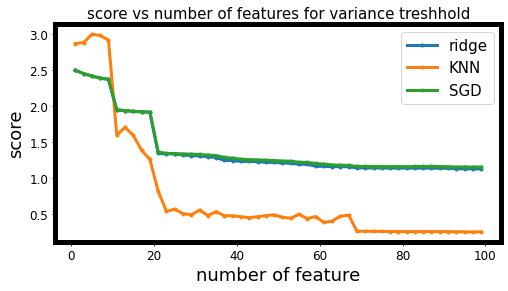

In [ ]:
x=range(1,100)
fig=plt.figure()
ax=fig.add_subplot(111,xlabel='number of feature',ylabel='score',title='score vs number of features for variance treshhold')
ax.plot(x[::2],scores_ridge[::2],'-o',label='ridge')
ax.plot(x[::2],scores_knn[::2],'-o',label='KNN')
ax.plot(x[::2],scores_sgd[::2],'-o',label='SGD')
ax.legend()

##Use PCA to transform our data

In [ ]:
%%time
from sklearn.decomposition import PCA 
pca=PCA()
pca_x=pca.fit_transform(m_X)

CPU times: user 15.5 s, sys: 701 ms, total: 16.2 s
Wall time: 8.38 s


In [ ]:
%%time
ridge_score_pca=[]
for i in range(1,100):
    rg.fit(pca_x[:,0:i],Y)
    Y_pred=rg.predict(pca_x[:,0:i])
    ridge_score_pca.append(score(Y.values,Y_pred))

CPU times: user 1.62 s, sys: 1.39 s, total: 3.01 s
Wall time: 1.53 s


In [ ]:
%%time
knn_score_pca=[] 
for i in range(1,100):
    knn.fit(pca_x[:,0:i],Y)
    Y_pred=knn.predict(pca_x[:,0:i])
    knn_score_pca.append(score(Y.values,Y_pred))

CPU times: user 1min 23s, sys: 158 ms, total: 1min 23s
Wall time: 1min 23s


In [ ]:
%%time
sgd_score_pca=[] 
for i in range(1,100):
    sgd.fit(pca_x[:,0:i],Y)
    Y_pred=sgd.predict(pca_x[:,0:i])
    sgd_score_pca.append(score(Y.values,Y_pred))

CPU times: user 28.6 s, sys: 9.33 s, total: 37.9 s
Wall time: 27.5 s


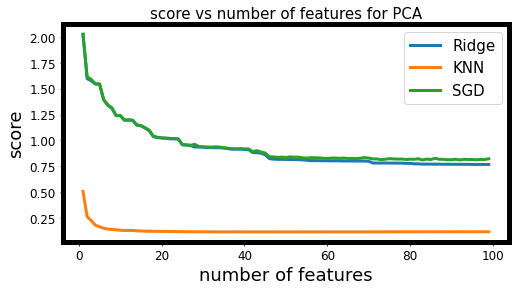

In [ ]:
fig2=plt.figure()
ax2=fig2.add_subplot(111,xlabel='number of features',ylabel='score',title='score vs number of features for PCA')
ax2.plot(range(1,100),ridge_score_pca,label='Ridge')
ax2.plot(range(1,100),knn_score_pca,label='KNN')
ax2.plot(range(1,100),sgd_score_pca,label='SGD')
plt.legend()
plt.show()

##TSNE

In [ ]:
%%time 
from sklearn.manifold import TSNE 
tsne=TSNE(n_components=3)
tsne_x=tsne.fit_transform(m_X)

CPU times: user 22min 12s, sys: 750 ms, total: 22min 13s
Wall time: 13min 16s


In [ ]:
tsne_x

array([[ 18.746262 ,  -6.8427916, -18.413034 ],
       [  2.0664392,   6.6075525,   3.282698 ],
       [  2.757831 , -27.497677 ,   1.7819227],
       ...,
       [ -8.419995 ,   4.4676423, -26.086576 ],
       [ -6.985139 ,  18.016909 ,   7.557495 ],
       [ -7.0111933,  17.958256 ,   7.572345 ]], dtype=float32)

In [ ]:
%%time
ridge_tsne_score=[]
for i in range(1,4):
    rg.fit(tsne_x[:,0:i],Y)
    Y_pred=rg.predict(tsne_x[:,0:i])
    ridge_tsne_score.append(score(Y,Y_pred))
    print(i)

1
2
3


In [ ]:
%%time
knn_tsne_score=[]
for i in range(1,4):
  knn.fit(tsne_x[:,0:i],Y)
  Y_pred=knn.predict(tsne_x[:,0:i])
  knn_tsne_score.append(score(Y,Y_pred))
  print(i)

1
2
3
CPU times: user 114 ms, sys: 0 ns, total: 114 ms
Wall time: 120 ms


In [ ]:
%%time 
sgd_tsne_score=[]
for i in range(1,4):
  sgd.fit(tsne_x[:,0:i],Y)
  Y_pred=sgd.predict(tsne_x[:,0:i])
  sgd_tsne_score.append(score(Y,Y_pred))
  print(i)

1
2
3
CPU times: user 298 ms, sys: 117 ms, total: 415 ms
Wall time: 296 ms


([<matplotlib.axis.XTick at 0x7f624e022790>,
 <a list of 3 Text major ticklabel objects>)

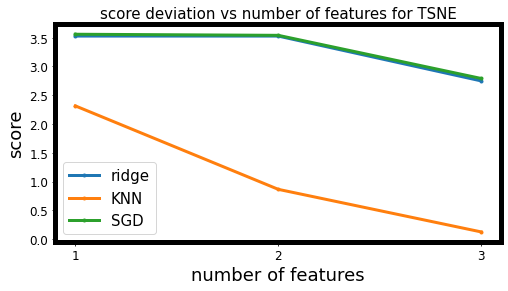

In [ ]:
x=range(1,4)
plt.plot(x,ridge_tsne_score,'-o',label='ridge')
plt.plot(x,knn_tsne_score,'-o',label='KNN')
plt.plot(x,sgd_tsne_score,'-o',label='SGD')
plt.title('score deviation vs number of features for TSNE')
plt.xlabel('number of features')
plt.ylabel('score')
plt.legend()
plt.xticks([1,2,3])